In [164]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import h5netcdf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm

In [165]:
path = r"D:\Historical KTC Datasets\MPI-ESM1-2-LR_KTC_Historical_dataset"
KTC = xr.open_dataset(path)
path2 = r"D:\2085-99 KTC Data\MPI-ESM1-2-LR_complete_KTC_SSP2-4.5_dataset_2085-2099.nc"
KTC_90 = xr.open_dataset(path2)

In [166]:
zone_ids = {'A->xA': 1, 'B->xA':2, 'C->xA':3, 'B->A':4, 'C->A':5, 'A->B':6, 'C->B':7, 'D->B':8, 'E->B':9, 
            'B->C':10, 'D->C':11, 'F->C':12, 'E->D':13, 'F->D':14, 'F->E': 15 } 

zone_colors = {'A->xA': 'darkblue', 'B->xA':'darkslateblue', 'C->xA':'blue', 'B->A':'deepskyblue', 
               'C->A':'lightskyblue', 'A->B':'darkred', 'C->B':'firebrick', 'D->B':'red', 'E->B':'orangered', 
               'B->C':'goldenrod', 'D->C':'gold', 'F->C':'yellow', 'E->D':'lightseagreen', 'F->D':'aqua', 
               'F->E':'paleturquoise' } 

In [167]:
zones20 = {
    'A': KTC['A'],
    'B': KTC['B'],
    'C': KTC['C'],
    'D': KTC['D'],
    'E': KTC['E'],
    'F': KTC['F']
}

KTC_90['xA'] = (KTC_90['xAr'] + KTC_90['xAw']).astype(bool)

zones90 = {
    'xA': KTC_90['xA'],
    'A':  KTC_90['A'],
    'B':  KTC_90['B'],
    'C':  KTC_90['C'],
    'D':  KTC_90['D'],
    'E':  KTC_90['E'],
    'F':  KTC_90['F']
}

In [168]:
def collapse_zone_masks(zone_dict, zone_order=None):
    first_key = list(zone_dict.keys())[0]
    shape = zone_dict[first_key].shape
    out = np.full(shape, '', dtype=object)

    keys = zone_order if zone_order else list(zone_dict.keys())

    for label in keys:
        mask = zone_dict[label].values.astype(bool)
        print(f"{label}: {mask.sum()} cells → writing '{label}'")
        out[mask] = label

    print("Total labeled cells:", np.count_nonzero(out != ''))
    return out

In [169]:
zone_order_20 = ["A", "B", "C", "D", "E", "F"]
zones_2020 = collapse_zone_masks(zones20, zone_order=zone_order_20)

zone_order_90 = ["A", "B", "C", "D", "E", "F", "xA"]
zones_2090 = collapse_zone_masks(zones90, zone_order=zone_order_90)

A: 473 cells → writing 'A'
B: 1070 cells → writing 'B'
C: 404 cells → writing 'C'
D: 815 cells → writing 'D'
E: 1149 cells → writing 'E'
F: 2311 cells → writing 'F'
Total labeled cells: 6222
A: 563 cells → writing 'A'
B: 1122 cells → writing 'B'
C: 356 cells → writing 'C'
D: 984 cells → writing 'D'
E: 998 cells → writing 'E'
F: 2199 cells → writing 'F'
xA: 0 cells → writing 'xA'
Total labeled cells: 6222


In [170]:
z20_str = zones_2020.astype(str)
z90_str = zones_2090.astype(str)

transitions = np.char.add(np.char.add(z20_str, "→"), z90_str)
transitions_str = np.char.replace(transitions, "→", "->")

In [171]:
flat_trans = transitions.flatten()
unique_trans = pd.unique(flat_trans)
trans_int = {label: i for i, label in enumerate(unique_trans)}

#make 2D array of integers representing transitions
int_map = np.vectorize(trans_int.get)(transitions)

In [172]:
#get a nicer arrow
transitions_str = np.char.replace(transitions, '→', '->') 
#default color for unmatched/no/same transitions 
default_color = "white"
#vectorize cmap
get_color = np.vectorize(lambda t: zone_colors.get(t, default_color))
cmap_array = get_color(transitions_str)  #2D array of color strings!

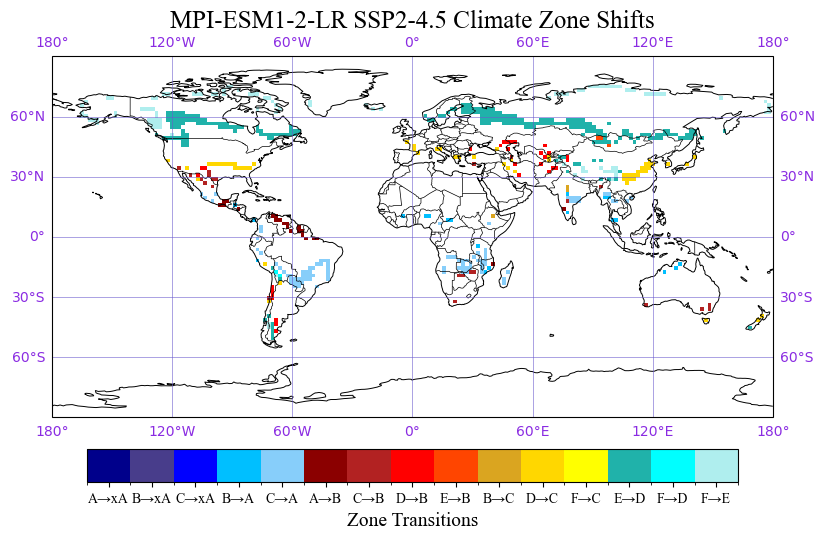

In [173]:
#convert color strings to RGB values
rgb_array = np.vectorize(mcolors.to_rgb)(cmap_array)  # shape: (3, lat, lon)
rgb_image = np.moveaxis(rgb_array, 0, -1)  # shape: (lat, lon, 3)

#define variables
lon = KTC['lon']
lat = KTC['lat']

#get cartopy features, build map
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=proj)
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='none')
ax.add_feature(cfeature.OCEAN, facecolor='white', edgecolor='none')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, 
                  color='slateblue', linewidth=0.4)
gl.xlabel_style = {"size": 10, "color": "blueviolet"}  #lon labels
gl.ylabel_style = {"size": 10, "color": "blueviolet"}  #lat labels

#overlay transitions
extent = [float(lon.min()), float(lon.max()), float(lat.min()), float(lat.max())]
ax.imshow(rgb_image, origin='lower', extent=extent, transform=ccrs.PlateCarree(), interpolation='none')

ax.imshow(
    rgb_image,
    origin='lower',
    extent=extent,
    transform=ccrs.PlateCarree(),
    interpolation='none'
)

ax.set_title("MPI-ESM1-2-LR SSP2-4.5 Climate Zone Shifts", fontsize=18, fontname='Times New Roman')

#sort zone ids and color ids to get order
sorted_items = sorted(zone_ids.items(), key=lambda x: x[1])
zone_labels = [k for k, _ in sorted_items]
zone_values = [v for _, v in sorted_items]
color_list = [mcolors.to_rgb(zone_colors[z]) for z in zone_labels]

#create cmap, norm, scalar mappable
cmap = ListedColormap(color_list)
bounds = zone_values + [max(zone_values) + 1]
norm = BoundaryNorm(bounds, cmap.N)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#set tick locations at centers of each color
#default sets them at borders of each color
tick_locs = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
#attach cbar to map
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.07, shrink=0.7, ticks=tick_locs)
cbar.set_label("Zone Transitions", fontsize=14, fontname='Times New Roman')
#get nicer arrow for the tick labels
pretty_labels = [label.replace('->', '→') for label in zone_labels]
cbar.set_ticklabels(pretty_labels)
for t in cbar.ax.get_xticklabels():
    t.set_fontname('Times New Roman')

#plt.savefig('/Users/jaybr/OneDrive/Desktop/RESEARCH/MPI-ESM1-2-LR_SSP2-4.5_transitions.png', dpi=300, bbox_inches='tight') 
plt.show()